In [1]:
import os
from pathlib import Path

from itertools import chain, product

import math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import time
from datetime import datetime, timedelta
import pymmwr

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [2]:
# config settings

# date of forecast generation
forecast_date = datetime.today().date()
#forecast_date = datetime(2025, 1, 15).date()
print(forecast_date)
 #"2024-10-13", "2024-11-24", "2024-12-22"

# next Saturday: weekly forecasts are relative to this date
ref_date = forecast_date - timedelta((forecast_date.weekday() + 2) % 7 - 7)
print(f'reference date = {ref_date}')

# maximum forecast horizon
max_horizon = 5

# bagging setup
num_bags = 100
bag_frac_samples = 0.7

# quantile levels at which to generate predictions
q_levels = [0.025, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.975]
q_labels = ['0.025', '0.05', '0.1', '0.25', '0.5', '0.75',  '0.9', '0.95', '0.975']


2025-01-30
reference date = 2025-02-01


In [3]:
os.chdir('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting')

In [4]:
import sys
sys.path.append('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting/GBM/code')
import loader 


In [5]:
dat = pd.read_csv('/Users/dk29776/Dropbox/UTAustin/flu-metrocast/target-data/oracle-output.csv')
dat.target_end_date.max()
dat

,target_end_date,location,target,oracle_value
0,2016-01-02,Bronx,ILI ED visits,165
1,2016-01-02,Brooklyn,ILI ED visits,166
2,2016-01-02,Manhattan,ILI ED visits,84
3,2016-01-02,NYC,ILI ED visits,744
4,2016-01-02,Queens,ILI ED visits,280
...,...,...,...,...
2845,2025-02-01,Brooklyn,ILI ED visits,815
2846,2025-02-01,Manhattan,ILI ED visits,391
2847,2025-02-01,NYC,ILI ED visits,2807
2848,2025-02-01,Queens,ILI ED visits,698


In [6]:
nyc_population = pd.read_csv('/Users/dk29776/Dropbox/UTAustin/flu-metrocast/auxiliary-data/nyc_population.csv')
nyc_population

,location,population
0,Bronx,1419250
1,Brooklyn,2646306
2,Manhattan,1627788
3,Queens,2330124
4,Staten Island,492734
5,NYC,8516202


In [7]:
dat = dat.merge(nyc_population, on='location', how='left')
dat

,target_end_date,location,target,oracle_value,population
0,2016-01-02,Bronx,ILI ED visits,165,1419250
1,2016-01-02,Brooklyn,ILI ED visits,166,2646306
2,2016-01-02,Manhattan,ILI ED visits,84,1627788
3,2016-01-02,NYC,ILI ED visits,744,8516202
4,2016-01-02,Queens,ILI ED visits,280,2330124
...,...,...,...,...,...
2845,2025-02-01,Brooklyn,ILI ED visits,815,2646306
2846,2025-02-01,Manhattan,ILI ED visits,391,1627788
2847,2025-02-01,NYC,ILI ED visits,2807,8516202
2848,2025-02-01,Queens,ILI ED visits,698,2330124


In [8]:
dat['inc'] = dat['oracle_value']/(dat['population']/ 100000)
dat['target_end_date'] = pd.to_datetime(dat['target_end_date'])
dat.rename(columns={'population': 'pop'}, inplace=True)
dat.rename(columns={'target_end_date': 'wk_end_date'}, inplace=True)
dat = dat[['wk_end_date', 'location', 'inc', 'pop']]
dat = dat[dat['wk_end_date'] < pd.Timestamp(ref_date)]
dat

,wk_end_date,location,inc,pop
0,2016-01-02,Bronx,11.625859,1419250
1,2016-01-02,Brooklyn,6.272895,2646306
2,2016-01-02,Manhattan,5.160377,1627788
3,2016-01-02,NYC,8.736289,8516202
4,2016-01-02,Queens,12.016528,2330124
...,...,...,...,...
2839,2025-01-25,Brooklyn,73.574258,2646306
2840,2025-01-25,Manhattan,58.361408,1627788
2841,2025-01-25,NYC,78.708795,8516202
2842,2025-01-25,Queens,70.382520,2330124


In [9]:
dat['wk_end_date'].max()

Timestamp('2025-01-25 00:00:00')

In [10]:
# Create epiweek and year columns
dat_arrange = dat.assign(
    epiweek=dat['wk_end_date'].dt.isocalendar().week,
    year=dat['wk_end_date'].dt.year
)


dat_arrange['season_week'] = loader.convert_epiweek_to_season_week(dat_arrange['year'].to_numpy(), dat_arrange['epiweek'].to_numpy())
dat_arrange = loader.adjust_year_based_on_target_end_date(dat_arrange)
dat_arrange = dat_arrange.assign(
    season=lambda x: (
        x['year'] - ((x['epiweek'] <= 30) & (x['season_week'] >= 1))
    ).astype(str) + "/" +
    (
        (x['year'] - ((x['epiweek'] <= 30) & (x['season_week'] >= 1)) + 1)
    ).astype(str).str[-2:]
)

df = dat_arrange
df


,wk_end_date,location,inc,pop,epiweek,year,season_week,season
0,2016-01-02,Bronx,11.625859,1419250,53,2015,23,2015/16
1,2016-01-02,Brooklyn,6.272895,2646306,53,2015,23,2015/16
2,2016-01-02,Manhattan,5.160377,1627788,53,2015,23,2015/16
3,2016-01-02,NYC,8.736289,8516202,53,2015,23,2015/16
4,2016-01-02,Queens,12.016528,2330124,53,2015,23,2015/16
...,...,...,...,...,...,...,...,...
2839,2025-01-25,Brooklyn,73.574258,2646306,4,2025,27,2024/25
2840,2025-01-25,Manhattan,58.361408,1627788,4,2025,27,2024/25
2841,2025-01-25,NYC,78.708795,8516202,4,2025,27,2024/25
2842,2025-01-25,Queens,70.382520,2330124,4,2025,27,2024/25


In [11]:
df[(df['wk_end_date'] == '2025-01-04') ]

,wk_end_date,location,inc,pop,epiweek,year,season_week,season
2820,2025-01-04,Bronx,97.657213,1419250,1,2025,24,2024/25
2821,2025-01-04,Brooklyn,62.615586,2646306,1,2025,24,2024/25
2822,2025-01-04,Manhattan,51.726638,1627788,1,2025,24,2024/25
2823,2025-01-04,NYC,68.798274,8516202,1,2025,24,2024/25
2824,2025-01-04,Queens,67.678802,2330124,1,2025,24,2024/25
2825,2025-01-04,Staten Island,39.575105,492734,1,2025,24,2024/25


In [12]:
df[(df['year'] == 2020) & (df['epiweek'] == 53)]

,wk_end_date,location,inc,pop,epiweek,year,season_week,season
1566,2021-01-02,Bronx,11.625859,1419250,53,2020,23,2020/21
1567,2021-01-02,Brooklyn,7.179820,2646306,53,2020,23,2020/21
1568,2021-01-02,Manhattan,5.774708,1627788,53,2020,23,2020/21
1569,2021-01-02,NYC,8.207884,8516202,53,2020,23,2020/21
1570,2021-01-02,Queens,8.840731,2330124,53,2020,23,2020/21
1571,2021-01-02,Staten Island,3.653087,492734,53,2020,23,2020/21


In [13]:
df.wk_end_date.max()

Timestamp('2025-01-25 00:00:00')

In [14]:
df['log_pop'] = np.log(df['pop'])
df['inc_4rt'] = (df['inc'] + 0.01)**0.25
df['inc_4rt_scale_factor'] = df \
.assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt'])) \
.groupby(['location'])['inc_4rt_in_season'] \
.transform(lambda x: x.quantile(0.95))

df['inc_4rt_cs'] = df['inc_4rt'] / (df['inc_4rt_scale_factor'] + 0.01)
df['inc_4rt_center_factor'] = df \
.assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt_cs'])) \
.groupby(['location'])['inc_4rt_cs_in_season'] \
.transform(lambda x: x.mean())
df['inc_4rt_cs'] = df['inc_4rt_cs'] - df['inc_4rt_center_factor']
df
  

,wk_end_date,location,inc,pop,epiweek,year,season_week,season,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
0,2016-01-02,Bronx,11.625859,1419250,53,2015,23,2015/16,14.165639,1.846926,3.236656,-0.182732,0.751602
1,2016-01-02,Brooklyn,6.272895,2646306,53,2015,23,2015/16,14.788675,1.583215,2.799645,-0.194044,0.757537
2,2016-01-02,Manhattan,5.160377,1627788,53,2015,23,2015/16,14.302733,1.507928,2.707837,-0.200471,0.755297
3,2016-01-02,NYC,8.736289,8516202,53,2015,23,2015/16,15.957481,1.719713,2.919601,-0.170435,0.757448
4,2016-01-02,Queens,12.016528,2330124,53,2015,23,2015/16,14.661432,1.862237,2.931235,-0.130241,0.763390
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2839,2025-01-25,Brooklyn,73.574258,2646306,4,2025,27,2024/25,14.788675,2.928844,2.799645,0.284888,0.757537
2840,2025-01-25,Manhattan,58.361408,1627788,4,2025,27,2024/25,14.302733,2.764076,2.707837,0.261716,0.755297
2841,2025-01-25,NYC,78.708795,8516202,4,2025,27,2024/25,15.957481,2.978651,2.919601,0.259295,0.757448
2842,2025-01-25,Queens,70.382520,2330124,4,2025,27,2024/25,14.661432,2.896554,2.931235,0.221419,0.763390


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm

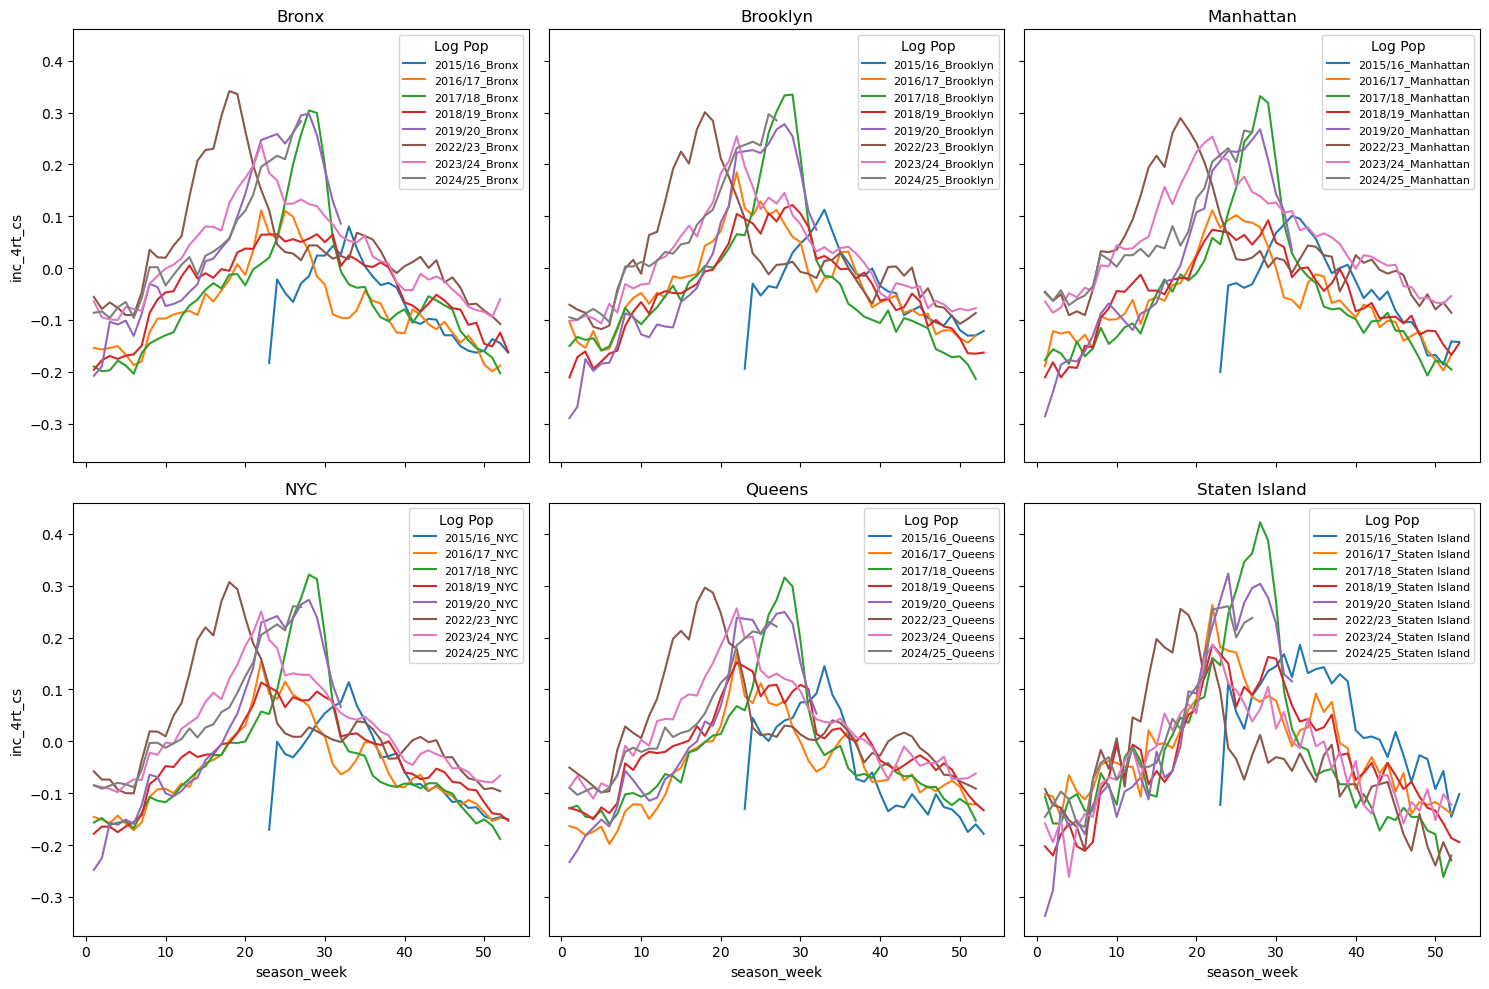

In [15]:
# Filter the DataFrame based on multiple conditions
# Exclude data from the 2020/21 and 2021/22 flu seasons (likely due to COVID-19 disruptions)
# Exclude data between March 1, 2020, and September 1, 2020 (likely due to COVID-19 disruptions)   
filtered_df = df[
    ~df['season'].isin(["2020/21", "2021/22"]) &
    ~((df['wk_end_date'] >= datetime(2020, 3, 1)) & (df['wk_end_date'] <= datetime(2020, 9, 1)))
]
# location 
locations = filtered_df['location'].unique()
nhsn_to_plot = filtered_df.assign(season_loc = lambda x: x['season'] + '_' + x['location'])

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  # 2D 배열을 1D로 평탄화

# figures by locations
for i, location in enumerate(locations):
    ax = axes[i]  # 각 subplot에 접근
    sns.lineplot(
        data=nhsn_to_plot[nhsn_to_plot['location'] == location],  # 특정 location 데이터만 선택
        x='season_week',
        y='inc_4rt_cs',
        units='season_loc',
        hue='season_loc',  # 색상은 log_pop 기준
        estimator=None,
        ci=None,
        ax=ax
    )
    ax.set_title(location)  # subplot 제목 설정
    ax.legend(title="Log Pop", fontsize=8)  # 범례 설정

# 빈 subplot 숨기기 (location 수가 6보다 적을 경우)
for j in range(len(locations), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [16]:
df = filtered_df

# we already have incidence (transformed scale), season week and log population
feat_names = ['inc_4rt_cs', 'season_week', 'log_pop']

# one-hot encodings of data source, agg_level, and location
for c in ['location']:
    ohe = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

# season week relative to christmas
df = df.merge(
    loader.get_holidays() \
      .query("holiday == 'Christmas Day'") \
      .drop(columns=['holiday', 'date']) \
      .rename(columns={'season_week': 'xmas_week'}),
    how='left',
    on='season') \
  .assign(delta_xmas = lambda x: x['season_week'] - x['xmas_week'])

feat_names = feat_names + ['delta_xmas']

In [17]:
df

,wk_end_date,location,inc,pop,epiweek,year,season_week,season,log_pop,inc_4rt,...,inc_4rt_cs,inc_4rt_center_factor,location_Bronx,location_Brooklyn,location_Manhattan,location_NYC,location_Queens,location_Staten Island,xmas_week,delta_xmas
0,2016-01-02,Bronx,11.625859,1419250,53,2015,23,2015/16,14.165639,1.846926,...,-0.182732,0.751602,1,0,0,0,0,0,21.0,2.0
1,2016-01-02,Brooklyn,6.272895,2646306,53,2015,23,2015/16,14.788675,1.583215,...,-0.194044,0.757537,0,1,0,0,0,0,21.0,2.0
2,2016-01-02,Manhattan,5.160377,1627788,53,2015,23,2015/16,14.302733,1.507928,...,-0.200471,0.755297,0,0,1,0,0,0,21.0,2.0
3,2016-01-02,NYC,8.736289,8516202,53,2015,23,2015/16,15.957481,1.719713,...,-0.170435,0.757448,0,0,0,1,0,0,21.0,2.0
4,2016-01-02,Queens,12.016528,2330124,53,2015,23,2015/16,14.661432,1.862237,...,-0.130241,0.763390,0,0,0,0,1,0,21.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,2025-01-25,Brooklyn,73.574258,2646306,4,2025,27,2024/25,14.788675,2.928844,...,0.284888,0.757537,0,1,0,0,0,0,NaN,NaN
2084,2025-01-25,Manhattan,58.361408,1627788,4,2025,27,2024/25,14.302733,2.764076,...,0.261716,0.755297,0,0,1,0,0,0,NaN,NaN
2085,2025-01-25,NYC,78.708795,8516202,4,2025,27,2024/25,15.957481,2.978651,...,0.259295,0.757448,0,0,0,1,0,0,NaN,NaN
2086,2025-01-25,Queens,70.382520,2330124,4,2025,27,2024/25,14.661432,2.896554,...,0.221419,0.763390,0,0,0,0,1,0,NaN,NaN


In [18]:
feat_names

['inc_4rt_cs',
 'season_week',
 'log_pop',
 'location_Bronx',
 'location_Brooklyn',
 'location_Manhattan',
 'location_NYC',
 'location_Queens',
 'location_Staten Island',
 'delta_xmas']

In [19]:
df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [4, 6],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [3, 5],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'inc_4rt_cs',
                'group_columns': ['location'],
                'window_size': [2, 4]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': ['inc_4rt_cs'] + new_feat_names,
                'lags': [1, 2]
            }
        }
    ])
feat_names = feat_names + new_feat_names

print(df)
print(feat_names)

     wk_end_date       location        inc      pop  epiweek  year  \
0     2016-01-02          Bronx  11.625859  1419250       53  2015   
1     2016-01-02       Brooklyn   6.272895  2646306       53  2015   
2     2016-01-02      Manhattan   5.160377  1627788       53  2015   
3     2016-01-02            NYC   8.736289  8516202       53  2015   
4     2016-01-02         Queens  12.016528  2330124       53  2015   
...          ...            ...        ...      ...      ...   ...   
2083  2025-01-25       Brooklyn  73.574258  2646306        4  2025   
2084  2025-01-25      Manhattan  58.361408  1627788        4  2025   
2085  2025-01-25            NYC  78.708795  8516202        4  2025   
2086  2025-01-25         Queens  70.382520  2330124        4  2025   
2087  2025-01-25  Staten Island  36.124968   492734        4  2025   

     season_week   season    log_pop   inc_4rt  ...  \
0             23  2015/16  14.165639  1.846926  ...   
1             23  2015/16  14.788675  1.583215  .

/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(taylor_coefs_one_column_grp,
/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this w

In [20]:
df.shape

(2088, 59)

In [21]:
new_feat_names

['inc_4rt_cs_lag1',
 'inc_4rt_cs_lag2',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2',
 'inc_4rt_cs_rollmean_w2_lag1',
 'inc_4rt_cs_rollmean_w2_lag2',
 'inc_4rt_cs_rollmean_w4_lag1',
 'in

In [22]:
# import importlib
# featurize = importlib.reload(featurize)

# last date with observed data
# last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
# print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
# due_date = forecast_date
# extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
# effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'inc_4rt_cs',
                'horizons': [(i+1) for i in range(max_horizon)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['inc_4rt_cs_target'] - df_with_pred_targets['inc_4rt_cs']

print(new_feat_names)
print(df_with_pred_targets)

['horizon']
     wk_end_date       location        inc      pop  epiweek  year  \
0     2016-01-02          Bronx  11.625859  1419250       53  2015   
1     2016-01-02       Brooklyn   6.272895  2646306       53  2015   
2     2016-01-02      Manhattan   5.160377  1627788       53  2015   
3     2016-01-02            NYC   8.736289  8516202       53  2015   
4     2016-01-02         Queens  12.016528  2330124       53  2015   
...          ...            ...        ...      ...      ...   ...   
2083  2025-01-25       Brooklyn  73.574258  2646306        4  2025   
2084  2025-01-25      Manhattan  58.361408  1627788        4  2025   
2085  2025-01-25            NYC  78.708795  8516202        4  2025   
2086  2025-01-25         Queens  70.382520  2330124        4  2025   
2087  2025-01-25  Staten Island  36.124968   492734        4  2025   

     season_week   season    log_pop   inc_4rt  ...  \
0             23  2015/16  14.165639  1.846926  ...   
1             23  2015/16  14.788675 

In [23]:
df_with_pred_targets.shape

(10440, 62)

In [24]:
df_with_pred_targets.wk_end_date.max()

Timestamp('2025-01-25 00:00:00')

In [25]:
df_with_pred_targets[df_with_pred_targets['inc_4rt_cs_target'].isna()]


,wk_end_date,location,inc,pop,epiweek,year,season_week,season,log_pop,inc_4rt,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
2082,2025-01-25,Bronx,127.461688,1419250,4,2025,27,2024/25,14.165639,3.360110,...,0.229625,0.025510,0.027387,-0.045349,-0.035984,-0.038248,-0.077737,NaN,1,NaN
2083,2025-01-25,Brooklyn,73.574258,2646306,4,2025,27,2024/25,14.788675,2.928844,...,0.255062,0.021501,0.021918,-0.022391,-0.052177,-0.035788,-0.054941,NaN,1,NaN
2084,2025-01-25,Manhattan,58.361408,1627788,4,2025,27,2024/25,14.302733,2.764076,...,0.229505,0.022376,0.021820,0.020110,-0.065513,-0.012619,-0.050748,NaN,1,NaN
2085,2025-01-25,NYC,78.708795,8516202,4,2025,27,2024/25,15.957481,2.978651,...,0.234660,0.022501,0.025092,0.033789,-0.035117,0.005699,-0.043647,NaN,1,NaN
2086,2025-01-25,Queens,70.382520,2330124,4,2025,27,2024/25,14.661432,2.896554,...,0.224345,0.022775,0.027511,0.053590,-0.031147,0.036850,-0.048330,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,2025-01-25,Brooklyn,73.574258,2646306,4,2025,27,2024/25,14.788675,2.928844,...,0.255062,0.021501,0.021918,-0.022391,-0.052177,-0.035788,-0.054941,NaN,5,NaN
2084,2025-01-25,Manhattan,58.361408,1627788,4,2025,27,2024/25,14.302733,2.764076,...,0.229505,0.022376,0.021820,0.020110,-0.065513,-0.012619,-0.050748,NaN,5,NaN
2085,2025-01-25,NYC,78.708795,8516202,4,2025,27,2024/25,15.957481,2.978651,...,0.234660,0.022501,0.025092,0.033789,-0.035117,0.005699,-0.043647,NaN,5,NaN
2086,2025-01-25,Queens,70.382520,2330124,4,2025,27,2024/25,14.661432,2.896554,...,0.224345,0.022775,0.027511,0.053590,-0.031147,0.036850,-0.048330,NaN,5,NaN


In [26]:
df_with_pred_targets2 = df_with_pred_targets.query("season_week >= 5 and season_week <= 45")

In [27]:
df_with_pred_targets2.shape

(8280, 62)

In [28]:
#date_list <- c("2023-10-01", "2023-11-05", "2023-12-10", "2024-01-14", "2024-02-18", "2024-03-24")

In [29]:
#df_with_pred_targets = df_with_pred_targets2
df_with_pred_targets = df_with_pred_targets2.drop(columns=['epiweek'])
    

# "test set" df used to generate look-ahead predictions
df_test = df_with_pred_targets \
    .loc[df_with_pred_targets.wk_end_date == df_with_pred_targets.wk_end_date.max()] \
    .copy()

x_test = df_test[feat_names]

# "train set" df for model fitting; target value non-missing
df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
x_train = df_train[feat_names]
y_train = df_train['delta_target']

In [30]:
df_test

,wk_end_date,location,inc,pop,year,season_week,season,log_pop,inc_4rt,inc_4rt_scale_factor,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
2082,2025-01-25,Bronx,127.461688,1419250,2025,27,2024/25,14.165639,3.360110,3.236656,...,0.229625,0.025510,0.027387,-0.045349,-0.035984,-0.038248,-0.077737,NaN,1,NaN
2083,2025-01-25,Brooklyn,73.574258,2646306,2025,27,2024/25,14.788675,2.928844,2.799645,...,0.255062,0.021501,0.021918,-0.022391,-0.052177,-0.035788,-0.054941,NaN,1,NaN
2084,2025-01-25,Manhattan,58.361408,1627788,2025,27,2024/25,14.302733,2.764076,2.707837,...,0.229505,0.022376,0.021820,0.020110,-0.065513,-0.012619,-0.050748,NaN,1,NaN
2085,2025-01-25,NYC,78.708795,8516202,2025,27,2024/25,15.957481,2.978651,2.919601,...,0.234660,0.022501,0.025092,0.033789,-0.035117,0.005699,-0.043647,NaN,1,NaN
2086,2025-01-25,Queens,70.382520,2330124,2025,27,2024/25,14.661432,2.896554,2.931235,...,0.224345,0.022775,0.027511,0.053590,-0.031147,0.036850,-0.048330,NaN,1,NaN
2087,2025-01-25,Staten Island,36.124968,492734,2025,27,2024/25,13.107725,2.451782,2.505080,...,0.254287,0.014384,0.032143,0.094145,-0.049186,0.063967,-0.042152,NaN,1,NaN
2082,2025-01-25,Bronx,127.461688,1419250,2025,27,2024/25,14.165639,3.360110,3.236656,...,0.229625,0.025510,0.027387,-0.045349,-0.035984,-0.038248,-0.077737,NaN,2,NaN
2083,2025-01-25,Brooklyn,73.574258,2646306,2025,27,2024/25,14.788675,2.928844,2.799645,...,0.255062,0.021501,0.021918,-0.022391,-0.052177,-0.035788,-0.054941,NaN,2,NaN
2084,2025-01-25,Manhattan,58.361408,1627788,2025,27,2024/25,14.302733,2.764076,2.707837,...,0.229505,0.022376,0.021820,0.020110,-0.065513,-0.012619,-0.050748,NaN,2,NaN
2085,2025-01-25,NYC,78.708795,8516202,2025,27,2024/25,15.957481,2.978651,2.919601,...,0.234660,0.022501,0.025092,0.033789,-0.035117,0.005699,-0.043647,NaN,2,NaN


In [31]:



# seed for random number generation, based on reference date
rng_seed = int(time.mktime(ref_date.timetuple()))
rng = np.random.default_rng(seed=rng_seed)
# seeds for lgb model fits, one per combination of bag and quantile level
lgb_seeds = rng.integers(1e8, size=(num_bags, len(q_levels)))

# training loop over bags
# for q_level, q_label in zip(q_levels, q_labels):
    # print(q_label)

oob_preds_by_bag = np.empty((x_train.shape[0], num_bags, len(q_levels)))
oob_preds_by_bag[:] = np.nan
test_preds_by_bag = np.empty((x_test.shape[0], num_bags, len(q_levels)))

train_seasons = df_train['season'].unique()

# Convert season_week and delta_xmas to numeric
x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')

x_test['season_week'] = pd.to_numeric(x_test['season_week'], errors='coerce')
x_test['delta_xmas'] = pd.to_numeric(x_test['delta_xmas'], errors='coerce')

#print(x_train.dtypes[x_train.dtypes == 'object'])
#print(x_test.dtypes[x_test.dtypes == 'object'])
# Initialize a DataFrame to store feature importances
feature_importance_df = pd.DataFrame(0, index=x_train.columns, columns=range(num_bags * len(q_levels)))


for b in range(num_bags):
    print(f'bag number {b+1}')
    # get indices of observations that are in bag
    bag_seasons = rng.choice(
        train_seasons,
        size = int(len(train_seasons) * bag_frac_samples),
        replace=False)
    bag_obs_inds = df_train['season'].isin(bag_seasons)
    
    for q_ind, q_level in enumerate(q_levels):
        # fit to bag
        model = lgb.LGBMRegressor(verbosity=-1,
                                    # hist_pool_size=1000,
                                    # objective='mean_absolute_error')
                                    objective='quantile',
                                    alpha = q_level,
                                    random_state=lgb_seeds[b, q_ind])
        model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
        
        # oob predictions and test set predictions
        #oob_preds_by_bag[~bag_obs_inds, b, q_ind] = model.predict(X=x_train.loc[~bag_obs_inds, :])
        test_preds_by_bag[:, b, q_ind] = model.predict(X=x_test)

        # Save feature importances
        col_idx = b * len(q_levels) + q_ind
        feature_importance_df.iloc[:, col_idx] = model.feature_importances_


# df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
# df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:21: SettingWithCo

bag number 1


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 2


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 3


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 4


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 5


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 6


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 7


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 8


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 9


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 10


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 11


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 12


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 13


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 14


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 15


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 16


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 17


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 18


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 19


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 20


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 21


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 22


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 23


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 24


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 25


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 26


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 27


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 28


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 29


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 30


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 31


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 32


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 33


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 34


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 35


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 36


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 37


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 38


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 39


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 40


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 41


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 42


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 43


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 44


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 45


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 46


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 47


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 48


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 49


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 50


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 51


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 52


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 53


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 54


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 55


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 56


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 57


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 58


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 59


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 60


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 61


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 62


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 63


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 64


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 65


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 66


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 67


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 68


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 69


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 70


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 71


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 72


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 73


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 74


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 75


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 76


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 77


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 78


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 79


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 80


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 81


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 82


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 83


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 84


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 85


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 86


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 87


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 88


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 89


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 90


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 91


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 92


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 93


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 94


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 95


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 96


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 97


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 98


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 99


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

bag number 100


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_importance_df.iloc[:, col_idx] = model.feature_importances_
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_26327/2589687871.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` wi

In [32]:
feature_importance_df['average_importance'] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(by='average_importance', ascending=False)
feature_importance_df

,0,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,average_importance
horizon,225,318,338,305,305,310,315,289,194,244,...,251,288,350,306,352,327,272,272,209,294.582222
season_week,202,202,251,278,298,328,288,278,246,157,...,152,187,227,235,226,210,224,198,175,186.752222
inc_4rt_cs,216,112,87,86,72,90,66,120,164,168,...,155,94,82,91,79,76,102,110,151,109.243333
inc_4rt_cs_rollmean_w2,123,115,134,111,120,137,99,115,113,116,...,114,125,113,95,96,97,104,100,103,106.984444
inc_4rt_cs_rollmean_w4_lag2,80,98,120,144,128,102,133,93,111,91,...,71,58,72,103,131,129,111,103,87,96.590000
inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,80,93,73,101,81,94,101,80,69,61,...,82,97,87,115,117,130,109,97,95,92.420000
delta_xmas,0,0,0,0,0,0,0,0,0,65,...,63,84,89,113,127,146,107,114,129,90.615556
inc_4rt_cs_taylor_d2_c1_w4t_sNone,116,83,86,70,70,73,102,97,119,103,...,110,84,75,83,80,87,81,88,88,87.031111
inc_4rt_cs_taylor_d1_c1_w5t_sNone,90,90,95,95,97,93,93,80,86,96,...,109,102,85,80,97,78,86,77,85,86.971111
inc_4rt_cs_rollmean_w4,98,112,105,127,116,109,87,85,87,70,...,74,98,85,95,95,89,60,70,60,84.214444


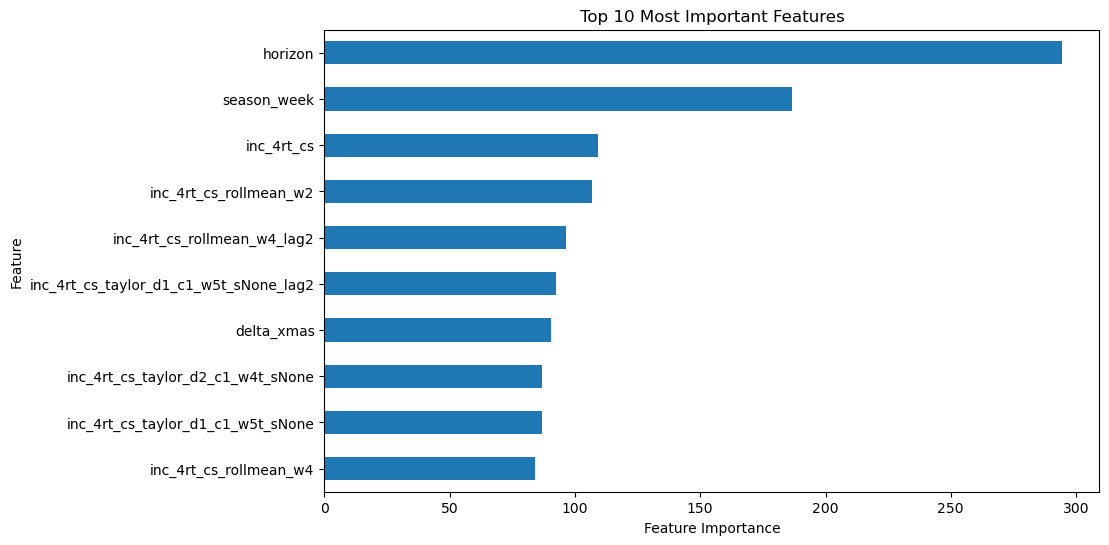

In [33]:
feature_importance_df['average_importance'].head(10).plot(kind='barh', figsize=(10, 6))
plt.title("Top 10 Most Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [34]:
#oob_pred_qs = np.nanmedian(oob_preds_by_bag, axis=1)
test_pred_qs = np.median(test_preds_by_bag, axis=1)
test_pred_qs_sorted = np.sort(test_pred_qs, axis=1)  # Sort to enforce monotonicity
test_pred_qs_sorted.shape

test_pred_qs_df = pd.DataFrame(test_pred_qs_sorted)
test_pred_qs_df.columns = q_labels
test_pred_qs_df

,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975
0,-0.109232,-0.065885,-0.044715,-0.019523,-0.005515,0.002209,0.003148,0.016513,0.038444
1,-0.126594,-0.084677,-0.052960,-0.026460,-0.016810,-0.009145,-0.002539,0.002146,0.036613
2,-0.107725,-0.066983,-0.044983,-0.021096,-0.005812,-0.002779,0.003612,0.009507,0.030719
3,-0.103016,-0.063475,-0.046464,-0.018072,-0.009037,-0.001921,-0.001531,0.011912,0.032748
4,-0.071159,-0.048057,-0.037031,-0.006856,0.008418,0.010408,0.011928,0.012885,0.037843
5,-0.123421,-0.078715,-0.060164,-0.012871,-0.000784,0.005686,0.007042,0.017910,0.039573
6,-0.109802,-0.077764,-0.063967,-0.042040,-0.027718,-0.022565,-0.012641,0.018754,0.041163
7,-0.139394,-0.104807,-0.080064,-0.048769,-0.047245,-0.039818,-0.032424,0.005148,0.037497
8,-0.109751,-0.078484,-0.061976,-0.043733,-0.031329,-0.026911,-0.013881,0.018386,0.037247
9,-0.110720,-0.075733,-0.067276,-0.046181,-0.036490,-0.029888,-0.018363,0.017205,0.037819


In [35]:
df_test.reset_index(drop=True, inplace=True)
df_test_w_preds = pd.concat([df_test, test_pred_qs_df], axis=1)
df_test_w_preds

,wk_end_date,location,inc,pop,year,season_week,season,log_pop,inc_4rt,inc_4rt_scale_factor,...,delta_target,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975
0,2025-01-25,Bronx,127.461688,1419250,2025,27,2024/25,14.165639,3.360110,3.236656,...,NaN,-0.109232,-0.065885,-0.044715,-0.019523,-0.005515,0.002209,0.003148,0.016513,0.038444
1,2025-01-25,Brooklyn,73.574258,2646306,2025,27,2024/25,14.788675,2.928844,2.799645,...,NaN,-0.126594,-0.084677,-0.052960,-0.026460,-0.016810,-0.009145,-0.002539,0.002146,0.036613
2,2025-01-25,Manhattan,58.361408,1627788,2025,27,2024/25,14.302733,2.764076,2.707837,...,NaN,-0.107725,-0.066983,-0.044983,-0.021096,-0.005812,-0.002779,0.003612,0.009507,0.030719
3,2025-01-25,NYC,78.708795,8516202,2025,27,2024/25,15.957481,2.978651,2.919601,...,NaN,-0.103016,-0.063475,-0.046464,-0.018072,-0.009037,-0.001921,-0.001531,0.011912,0.032748
4,2025-01-25,Queens,70.382520,2330124,2025,27,2024/25,14.661432,2.896554,2.931235,...,NaN,-0.071159,-0.048057,-0.037031,-0.006856,0.008418,0.010408,0.011928,0.012885,0.037843
5,2025-01-25,Staten Island,36.124968,492734,2025,27,2024/25,13.107725,2.451782,2.505080,...,NaN,-0.123421,-0.078715,-0.060164,-0.012871,-0.000784,0.005686,0.007042,0.017910,0.039573
6,2025-01-25,Bronx,127.461688,1419250,2025,27,2024/25,14.165639,3.360110,3.236656,...,NaN,-0.109802,-0.077764,-0.063967,-0.042040,-0.027718,-0.022565,-0.012641,0.018754,0.041163
7,2025-01-25,Brooklyn,73.574258,2646306,2025,27,2024/25,14.788675,2.928844,2.799645,...,NaN,-0.139394,-0.104807,-0.080064,-0.048769,-0.047245,-0.039818,-0.032424,0.005148,0.037497
8,2025-01-25,Manhattan,58.361408,1627788,2025,27,2024/25,14.302733,2.764076,2.707837,...,NaN,-0.109751,-0.078484,-0.061976,-0.043733,-0.031329,-0.026911,-0.013881,0.018386,0.037247
9,2025-01-25,NYC,78.708795,8516202,2025,27,2024/25,15.957481,2.978651,2.919601,...,NaN,-0.110720,-0.075733,-0.067276,-0.046181,-0.036490,-0.029888,-0.018363,0.017205,0.037819


In [36]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['wk_end_date' ,'location', 'pop',
                'inc_4rt_cs', 'horizon',
                'inc_4rt_center_factor', 'inc_4rt_scale_factor']
preds_df = df_test_w_preds[cols_to_keep + q_labels]
preds_df = pd.melt(preds_df,
                id_vars=cols_to_keep,
                var_name='quantile',
                value_name = 'delta_hat')
preds_df

,wk_end_date,location,pop,inc_4rt_cs,horizon,inc_4rt_center_factor,inc_4rt_scale_factor,quantile,delta_hat
0,2025-01-25,Bronx,1419250,0.283342,1,0.751602,3.236656,0.025,-0.109232
1,2025-01-25,Brooklyn,2646306,0.284888,1,0.757537,2.799645,0.025,-0.126594
2,2025-01-25,Manhattan,1627788,0.261716,1,0.755297,2.707837,0.025,-0.107725
3,2025-01-25,NYC,8516202,0.259295,1,0.757448,2.919601,0.025,-0.103016
4,2025-01-25,Queens,2330124,0.221419,1,0.763390,2.931235,0.025,-0.071159
...,...,...,...,...,...,...,...,...,...
265,2025-01-25,Brooklyn,2646306,0.284888,5,0.757537,2.799645,0.975,0.050557
266,2025-01-25,Manhattan,1627788,0.261716,5,0.755297,2.707837,0.975,0.057061
267,2025-01-25,NYC,8516202,0.259295,5,0.757448,2.919601,0.975,0.056560
268,2025-01-25,Queens,2330124,0.221419,5,0.763390,2.931235,0.975,0.058042


In [37]:
# build data frame with predictions on the original scale
preds_df['inc_4rt_cs_target_hat'] = preds_df['inc_4rt_cs'] + preds_df['delta_hat']
preds_df['inc_4rt_target_hat'] = (preds_df['inc_4rt_cs_target_hat'] + preds_df['inc_4rt_center_factor']) * (preds_df['inc_4rt_scale_factor'] + 0.01)
preds_df['value'] = (np.maximum(preds_df['inc_4rt_target_hat'], 0.0) ** 4 - 0.01 - 0.75**4) * preds_df['pop'] / 100000
preds_df['value'] = np.maximum(preds_df['value'], 0.0)
preds_df

,wk_end_date,location,pop,inc_4rt_cs,horizon,inc_4rt_center_factor,inc_4rt_scale_factor,quantile,delta_hat,inc_4rt_cs_target_hat,inc_4rt_target_hat,value
0,2025-01-25,Bronx,1419250,0.283342,1,0.751602,3.236656,0.025,-0.109232,0.174110,3.005471,1153.368284
1,2025-01-25,Brooklyn,2646306,0.284888,1,0.757537,2.799645,0.025,-0.126594,0.158294,2.573161,1151.495323
2,2025-01-25,Manhattan,1627788,0.261716,1,0.755297,2.707837,0.025,-0.107725,0.153991,2.471296,601.838530
3,2025-01-25,NYC,8516202,0.259295,1,0.757448,2.919601,0.025,-0.103016,0.156278,2.676854,4344.852891
4,2025-01-25,Queens,2330124,0.221419,1,0.763390,2.931235,0.025,-0.071159,0.150260,2.687258,1207.507175
...,...,...,...,...,...,...,...,...,...,...,...,...
265,2025-01-25,Brooklyn,2646306,0.284888,5,0.757537,2.799645,0.975,0.050557,0.335445,3.070892,2344.774660
266,2025-01-25,Manhattan,1627788,0.261716,5,0.755297,2.707837,0.975,0.057061,0.318777,2.919158,1176.716578
267,2025-01-25,NYC,8516202,0.259295,5,0.757448,2.919601,0.975,0.056560,0.315855,3.144348,8296.903626
268,2025-01-25,Queens,2330124,0.221419,5,0.763390,2.931235,0.975,0.058042,0.279461,3.067268,2054.857052


In [38]:
# keep just required columns and rename to match hub format
preds_df = preds_df[['wk_end_date', 'location', 'horizon', 'quantile', 'value']] \
    .rename(
        columns={
            'quantile': 'output_type_id'
        })

preds_df['target_end_date'] = preds_df['wk_end_date'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
preds_df['reference_date'] = ref_date
preds_df['target'] = 'ILI ED visits'
preds_df['horizon'] = preds_df['horizon'] - 1

preds_df['output_type'] = 'quantile'
preds_df



,wk_end_date,location,horizon,output_type_id,value,target_end_date,reference_date,target,output_type
0,2025-01-25,Bronx,0,0.025,1153.368284,2025-02-01,2025-02-01,ILI ED visits,quantile
1,2025-01-25,Brooklyn,0,0.025,1151.495323,2025-02-01,2025-02-01,ILI ED visits,quantile
2,2025-01-25,Manhattan,0,0.025,601.838530,2025-02-01,2025-02-01,ILI ED visits,quantile
3,2025-01-25,NYC,0,0.025,4344.852891,2025-02-01,2025-02-01,ILI ED visits,quantile
4,2025-01-25,Queens,0,0.025,1207.507175,2025-02-01,2025-02-01,ILI ED visits,quantile
...,...,...,...,...,...,...,...,...,...
265,2025-01-25,Brooklyn,4,0.975,2344.774660,2025-03-01,2025-02-01,ILI ED visits,quantile
266,2025-01-25,Manhattan,4,0.975,1176.716578,2025-03-01,2025-02-01,ILI ED visits,quantile
267,2025-01-25,NYC,4,0.975,8296.903626,2025-03-01,2025-02-01,ILI ED visits,quantile
268,2025-01-25,Queens,4,0.975,2054.857052,2025-03-01,2025-02-01,ILI ED visits,quantile


In [39]:
preds_df = preds_df[['reference_date', 'location', 'horizon', 'target', 'target_end_date', 'output_type', 'output_type_id', 'value']]
preds_df

,reference_date,location,horizon,target,target_end_date,output_type,output_type_id,value
0,2025-02-01,Bronx,0,ILI ED visits,2025-02-01,quantile,0.025,1153.368284
1,2025-02-01,Brooklyn,0,ILI ED visits,2025-02-01,quantile,0.025,1151.495323
2,2025-02-01,Manhattan,0,ILI ED visits,2025-02-01,quantile,0.025,601.838530
3,2025-02-01,NYC,0,ILI ED visits,2025-02-01,quantile,0.025,4344.852891
4,2025-02-01,Queens,0,ILI ED visits,2025-02-01,quantile,0.025,1207.507175
...,...,...,...,...,...,...,...,...
265,2025-02-01,Brooklyn,4,ILI ED visits,2025-03-01,quantile,0.975,2344.774660
266,2025-02-01,Manhattan,4,ILI ED visits,2025-03-01,quantile,0.975,1176.716578
267,2025-02-01,NYC,4,ILI ED visits,2025-03-01,quantile,0.975,8296.903626
268,2025-02-01,Queens,4,ILI ED visits,2025-03-01,quantile,0.975,2054.857052


In [40]:
if not Path('GBQR/model_output/NYC_ED').exists():
    Path('GBQR/model_output/NYC_ED').mkdir(parents=True)

preds_df.to_csv(f'GBQR/model_output/NYC_ED/{str(ref_date)}-wo-2season-epiENGAGE-GBQR.csv', index=False)
